In [1]:
import numpy as np
import tofpipe
import matplotlib.pyplot as plt
import time
from scipy.ndimage import gaussian_filter
from skimage.measure import label
from scipy import ndimage
import numpy as np
import utils
import os
import scipy

In [2]:
clean_plate_phase = np.load('data\\clean\\phase_img_1.npy')
vehicle_capture_phase = np.load('data\\large_car\\phase_img1.npy')

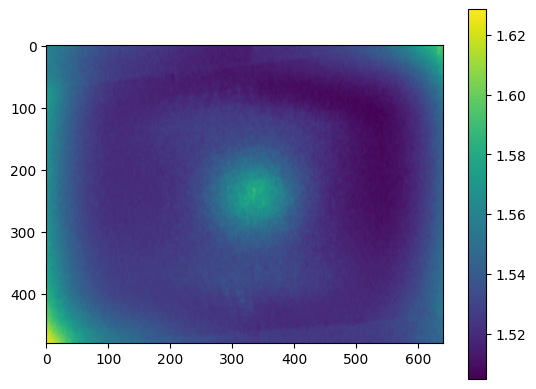

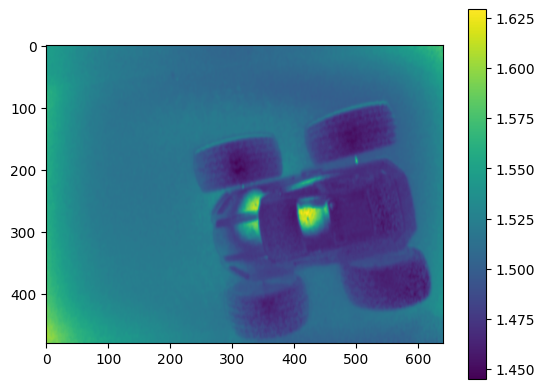

In [3]:
# Plot the images
plt.imshow(clean_plate_phase)
plt.colorbar()
plt.show()
plt.imshow(vehicle_capture_phase)
plt.colorbar()
plt.show()

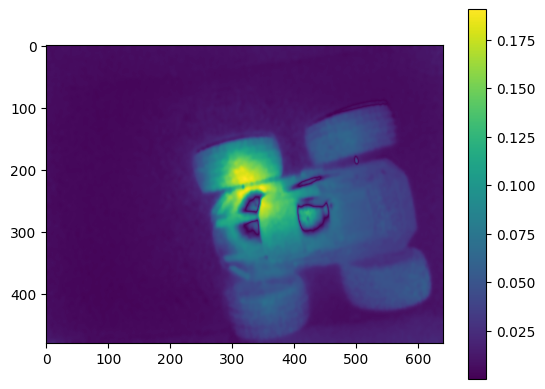

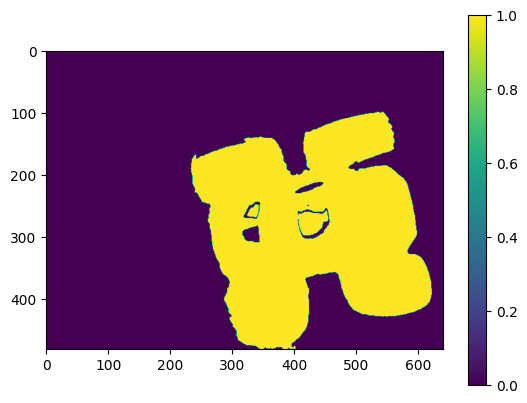

0.7266245522514181


In [4]:
axis_scales = [.002, .002]
verbose = False
alphas = np.zeros_like(clean_plate_phase)
for i in range(alphas.shape[0]):
    for j in range(alphas.shape[1]):
        alphas[i, j] = (axis_scales[0]**2 * (i - alphas.shape[0] / 2)**2 + axis_scales[1]**2 * (j - alphas.shape[1] / 2)**2)**0.5
def preprocess_image(image):
    image = np.nan_to_num(image)
    image = gaussian_filter(image, 1)
    return image
def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

test = preprocess_image(vehicle_capture_phase) - preprocess_image(clean_plate_phase)
test = scipy.signal.wiener(test, mysize=(5, 5))
test *= 2 / (alphas + 1)**2
test = np.abs(test)
plt.imshow(test)
plt.colorbar()
plt.show()
car_cutoff = 0.02
car_silhouette = test > car_cutoff
#car_silhouette = scipy.ndimage.percentile_filter(car_silhouette, 0.7, size=5)
if np.sum(car_silhouette) > 0:
    car_silhouette = getLargestCC(car_silhouette)
    plt.imshow(car_silhouette)
    plt.colorbar()
    plt.show()
    car_silhouette_where = np.where(car_silhouette == 1)
    min_width = np.min(car_silhouette_where[0])
    max_width = np.max(car_silhouette_where[0])
    min_depth = np.min(car_silhouette_where[1])
    max_depth = np.max(car_silhouette_where[1])
    if verbose:
        print("Width: ", max_width - min_width)
        print("Depth: ", max_depth - min_depth)
    n_pixels = 40
    left_pixels = (car_silhouette_where[0][-n_pixels:], car_silhouette_where[1][-n_pixels:])
    right_pixels = (car_silhouette_where[0][:n_pixels], car_silhouette_where[1][:n_pixels])
    depth_map = scipy.signal.wiener(preprocess_image(vehicle_capture_phase)) * 0.66
    depth_map = scipy.signal.medfilt(depth_map, 3)
    def get_mean_x_displacement(pixel_locations):
        distances = depth_map[pixel_locations[0], pixel_locations[1]]
        if verbose:
            print(np.mean(distances))
        return distances * np.sin(axis_scales[0] * (pixel_locations[0] - alphas.shape[0] / 2))
    proper_width = np.mean(get_mean_x_displacement(left_pixels) - get_mean_x_displacement(right_pixels))
    print(proper_width)

In [5]:
utils.measure_vehicle_width(clean_plate_phase, vehicle_capture_phase)

0.121104092041903

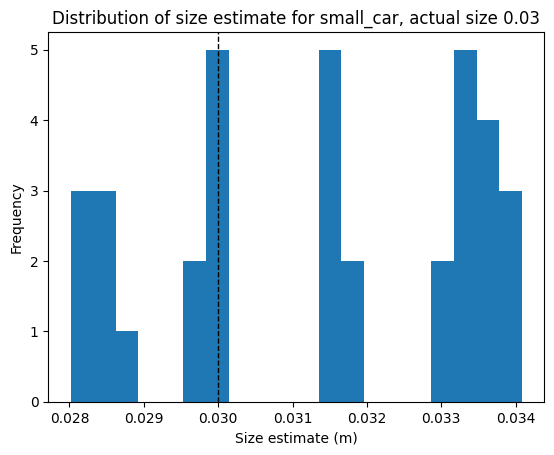

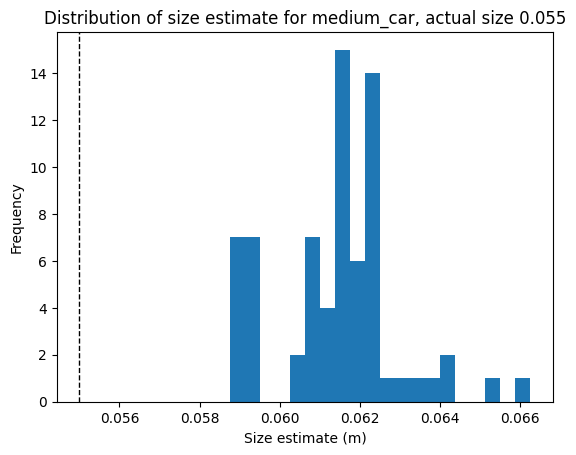

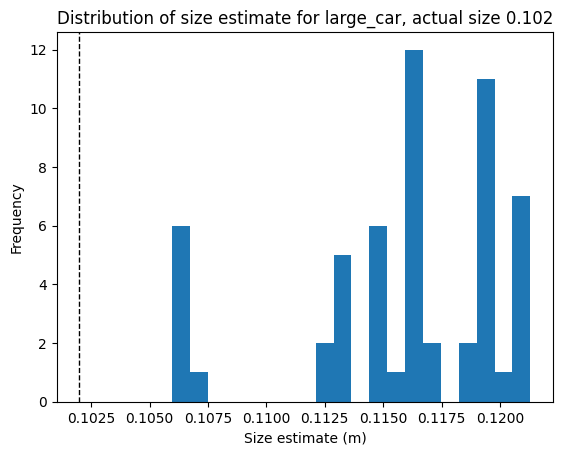

In [6]:
actual_widths = {'small_car': 0.03, 'medium_car': 0.055, 'large_car': 0.102}
clean_path = 'data\\clean\\'
for car in actual_widths:
    folder_path = 'data\\' + car + '\\'
    files = os.listdir(folder_path)
    widths = []
    for file in files:
        for clean_file in os.listdir(clean_path):
            clean_plate_phase = np.load(clean_path + clean_file)
            vehicle_capture_phase = np.load(folder_path + file)
            size = utils.measure_vehicle_width(clean_plate_phase, vehicle_capture_phase)
            if size is None:
                size = 0
            widths.append(size)
    plt.hist(widths, bins=20)
    plt.xlabel('Size estimate (m)')
    plt.ylabel('Frequency')
    plt.axvline(actual_widths[car], color='k', linestyle='dashed', linewidth=1)
    plt.title(f'Distribution of size estimate for {car}, actual size {actual_widths[car]}')
    plt.show()